## Jo Martin - Week 3 Exercise
I know you didn't want the code but it was easier for me to do it this way.  Also I used python.  I beg your forgiveness for the selfishness that runs through my attempt on this assignment.

In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

sklearn doesn't have a built in silhouette plot function so I asked ChatGPT

In [2]:
def plot_silhouette(X, labels, fig, ax):
    """
    Creates a silhouette plot for clustering results.

    Parameters:
    - X: ndarray of shape (n_samples, n_features)
      The dataset used for clustering.
    - labels: ndarray of shape (n_samples,)
      Cluster labels assigned to each sample.
    """
    n_clusters = len(set(labels))
    
    # Compute silhouette scores
    silhouette_avg = silhouette_score(X, labels)
    sample_silhouette_values = silhouette_samples(X, labels)

    # Create the silhouette plot
    y_lower = 10  # Spacing between clusters

    for i in range(n_clusters):
        # Extract silhouette scores for the current cluster
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Compute where to start the next cluster
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Pick a color from the colormap
        color = cm.nipy_spectral(float(i) / n_clusters)
        
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        # Label the silhouette plots with cluster numbers
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        # Move to the next cluster
        y_lower = y_upper + 10

    # Formatting the plot
    ax.set_title(f"Silhouette Plot for {n_clusters} Clusters")
    ax.set_xlabel("Silhouette Score")
    ax.set_ylabel("Cluster")
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")  # Average silhouette score line
    ax.set_yticks([])  # No y-axis ticks
    ax.set_xlim([-0.1, 1])  # Silhouette scores range from -1 to 1


# Some background information
- SWE (Snow water equivalent)
  If you melted the snow, how deep would the water be (in mm)?
- SDD  (Snow disspearence date) Date that snow dissapered as calculated by MODIS
## Make maps and plots of the data

In [3]:
SWE_path = "Exercise week 3/swe_2019.mat"
SDD_path = "Exercise week 3/sdd_2019.mat"
elv_path = "Exercise week 3/z_2019.mat"

In [4]:
swe_arr = loadmat(SWE_path)['swe']
sdd_arr = loadmat(SDD_path)['sdd']
elv_arr = loadmat(elv_path)['z']

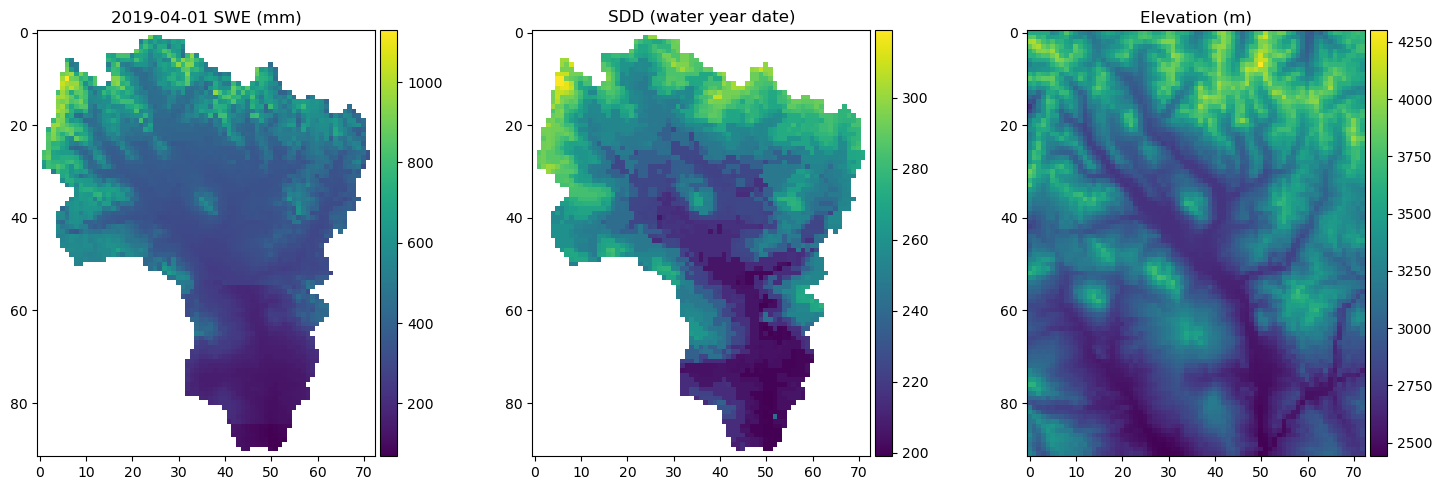

In [5]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
swe_im = ax[0].imshow(swe_arr[::-1])
ax[0].set_title("2019-04-01 SWE (mm)")
sdd_im = ax[1].imshow(sdd_arr[::-1])
ax[1].set_title("SDD (water year date)")
elv_im = ax[2].imshow(elv_arr[::-1])
ax[2].set_title("Elevation (m)")
d1 = make_axes_locatable(ax[0])
cax1 = d1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(swe_im, cax=cax1)
d2 = make_axes_locatable(ax[1])
cax2 = d2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(sdd_im, cax=cax2)
d3 = make_axes_locatable(ax[2])
cax3 = d3.append_axes("right", size="5%", pad=0.05)
fig.colorbar(elv_im, cax=cax3)
fig.tight_layout()

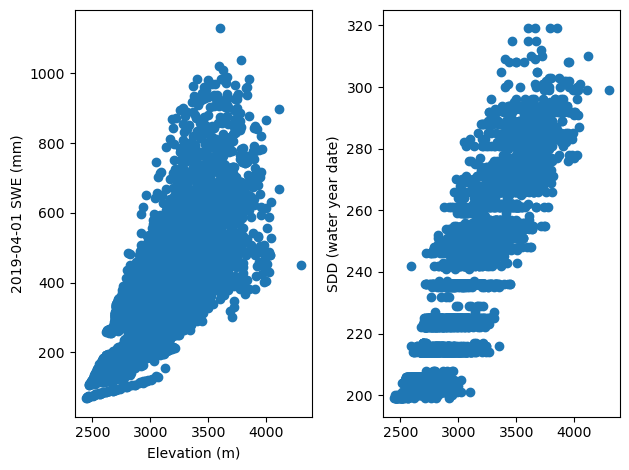

In [6]:
fig, ax = plt.subplots(1,2)
ax[0].scatter(elv_arr, swe_arr)
ax[1].scatter(elv_arr, sdd_arr)
ax[0].set_xlabel("Elevation (m)")
ax[0].set_ylabel("2019-04-01 SWE (mm)")
ax[1].set_ylabel("SDD (water year date)")
fig.tight_layout()

We see that SWE and SDD generally increases with elevation.

# Dataset reorganization

In [7]:
swe = swe_arr.flatten()
sdd = sdd_arr.flatten()
elv = elv_arr.flatten()
snow_df = pd.DataFrame({'swe': swe, 'sdd': sdd, 'elv': elv})

In [8]:
snow_df = snow_df[snow_df[['swe', 'sdd', 'elv']].notnull().all(1)]

In [9]:
snow_df

,swe,sdd,elv
117,113.530078,208.0,2946.950928
118,106.195129,214.0,2870.727051
123,81.348161,199.0,2568.769775
124,68.244855,199.0,2441.636475
189,117.125781,208.0,2951.126465
...,...,...,...
6527,655.178295,292.0,3942.915527
6528,704.164382,294.0,3932.529053
6594,901.423235,281.0,3744.419678
6595,674.370794,299.0,3777.940186


Reorganization successful!

# Question 2

First, some functions for clustering to re-use later

In [10]:
def cluster(data, variables, clusters):
    km = KMeans(clusters)
    km.fit(data[variables].values)
    new_df = data.copy()
    new_df['cluster'] = km.labels_
    return new_df, km

def plot_cluster(data, x_var, y_var, km):
    sns.set_palette("Set2")
    palette = sns.color_palette()
    ax = sns.scatterplot(data=data, x=x_var, y=y_var, hue='cluster', palette="Set2")
    for i, center  in enumerate(km.cluster_centers_):
        ax.plot(*center[:2], 'o', markersize=10, markerfacecolor='w', markeredgecolor=palette[i], markeredgewidth=3)    

Now, cluster SWE and SDD with 2 clusters

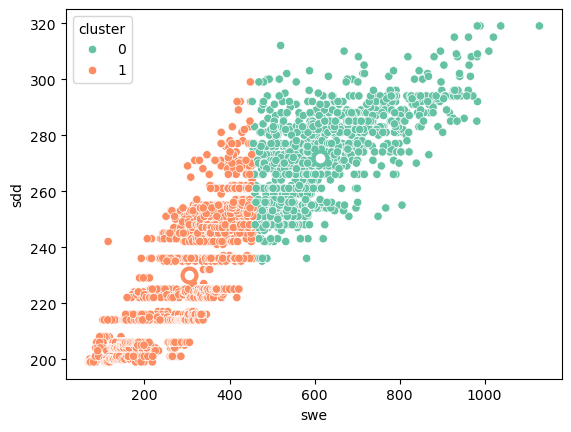

In [11]:
clusterd_data, km = cluster(snow_df, ['swe', 'sdd'], 2)
plot_cluster(clusterd_data, 'swe', 'sdd', km)

This does not look like a great clustering.  The cluster seems to mostly be SWE above and below about 500.

Lets try 3 clusters

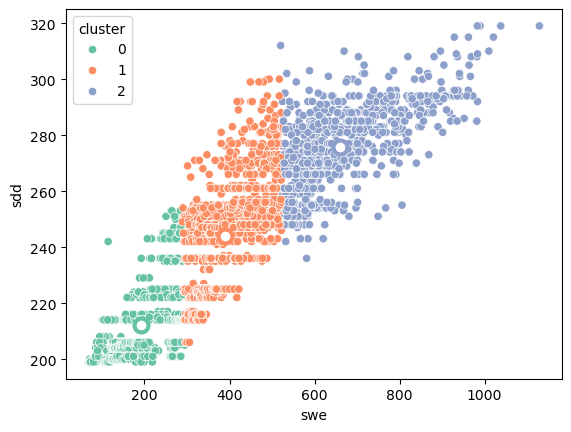

In [12]:
clusterd_data, km = cluster(snow_df, ['swe', 'sdd'], 3)
plot_cluster(clusterd_data, 'swe', 'sdd', km)

# Question 3
I guess we would need to calculate the distance between each point and it's cluster centroid.  And then try moving the centroid, recalculating the distance, and seeing how the total distance changed.  Of course, when you move a centroid, wouldn't some points flip clusters?  This seems like a pain.  Maybe you could do something cool with gradiants and minimization??

# Question 4
Include Elevation in our clustering, for 2 and 3 clusters

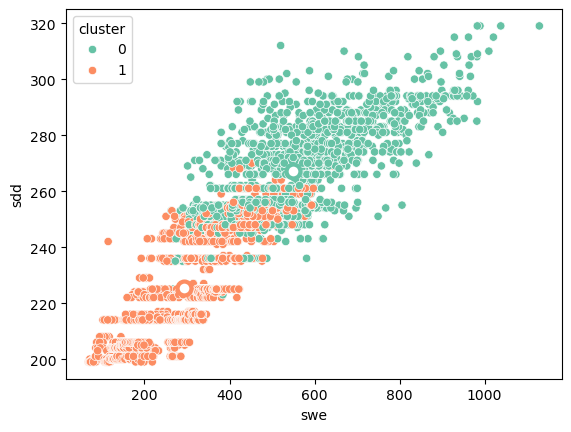

In [13]:
clusterd_data, km = cluster(snow_df, ['swe', 'sdd', 'elv'], 2)
plot_cluster(clusterd_data, 'swe', 'sdd', km)

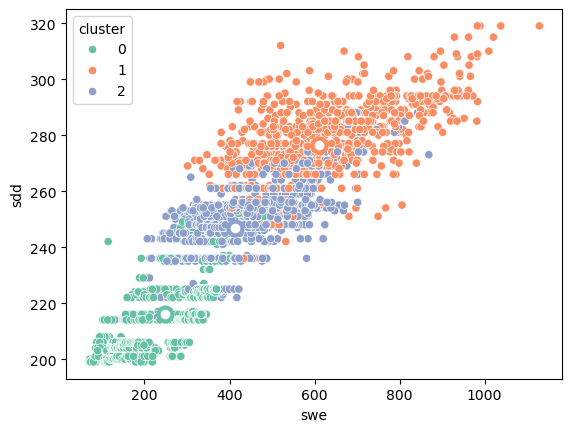

In [14]:
clusterd_data, km = cluster(snow_df, ['swe', 'sdd', 'elv'], 3)
plot_cluster(clusterd_data, 'swe', 'sdd', km)

Here our clusters overlap, because we are looking at the projection of 3d points into 2d space.

# Question 5

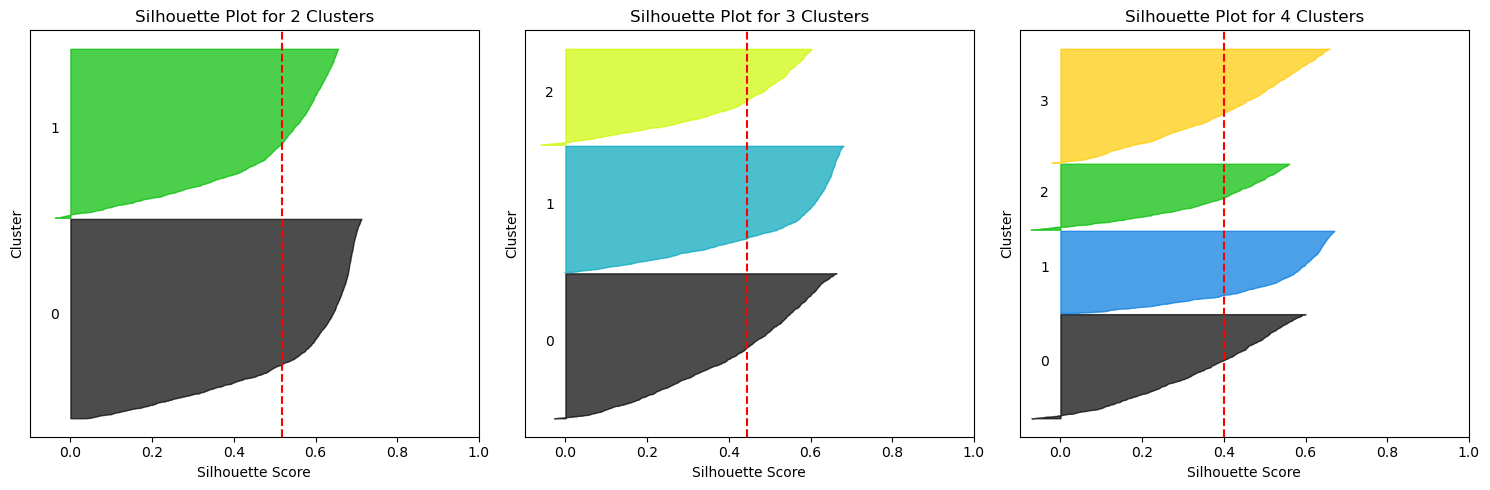

In [15]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))
clusterd_data2, km = cluster(snow_df, ['swe', 'sdd', 'elv'], 2)
clusterd_data3, km = cluster(snow_df, ['swe', 'sdd', 'elv'], 3)
clusterd_data4, km = cluster(snow_df, ['swe', 'sdd', 'elv'], 4)
plot_silhouette(clusterd_data2[['swe', 'sdd', 'elv']], clusterd_data2["cluster"], fig, axs[0])
plot_silhouette(clusterd_data3[['swe', 'sdd', 'elv']], clusterd_data3["cluster"], fig, axs[1])
plot_silhouette(clusterd_data4[['swe', 'sdd', 'elv']], clusterd_data4["cluster"], fig, axs[2])
fig.tight_layout()

I Think 2 clusters has the best distribution, but I'm still a little unsure...maybe 3 is pretty good too.

# Question 6

In [16]:
full_index=np.arange(swe_arr.shape[0]*swe_arr.shape[1])
c2_full = clusterd_data2['cluster'].reindex(full_index)
c2_arr = c2_full.values.reshape(*swe_arr.shape)
full_index=np.arange(swe_arr.shape[0]*swe_arr.shape[1])
c3_full = clusterd_data3['cluster'].reindex(full_index)
c3_arr = c3_full.values.reshape(*swe_arr.shape)
full_index=np.arange(swe_arr.shape[0]*swe_arr.shape[1])
c4_full = clusterd_data4['cluster'].reindex(full_index)
c4_arr = c4_full.values.reshape(*swe_arr.shape)

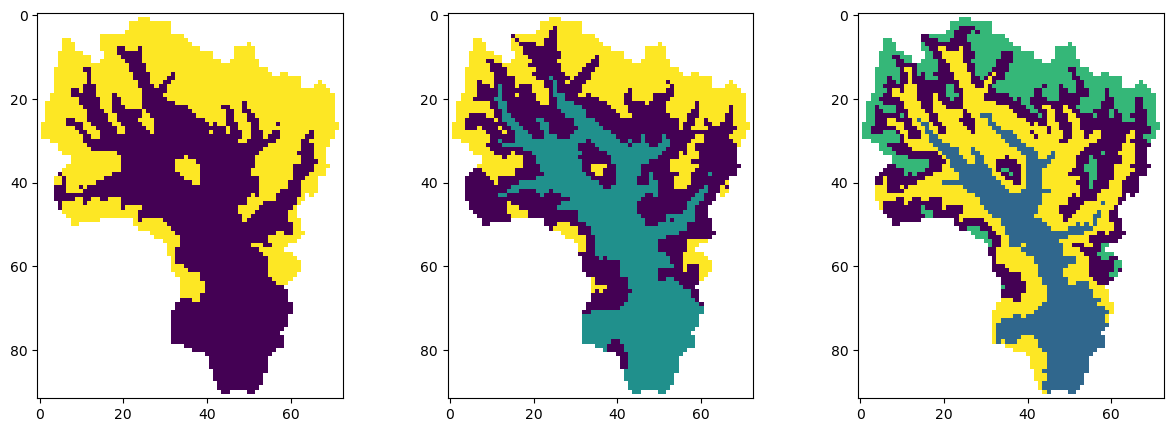

In [17]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(c2_arr[::-1])
ax[1].imshow(c3_arr[::-1])
ax[2].imshow(c4_arr[::-1])